In [1]:
#### Now since this is a new file we need to import other modules (YAY!) including our R' emulator
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

### and let's not forget the usual gang:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
import os 

In [2]:
#### Before we get started in an R' environment. We need to talk about something important.
#### Rentrez does not use SNP ID to search. It uses UID. As in, they don't use 'rs2000' 
#### but rather '2000'. So we need to use our previous output and split the function.
Output_GeneSNP_file = pd.read_csv('Resources/OutputFromExtractionCode/Editable_Gene_And_dbSNP_ID.csv')
Output_GeneSNP_file.head(10)

output_path = 'Resources/OutputFromExtractionCode'

In [3]:
### Now we split it. 
Split_dbSNP_ID = Output_GeneSNP_file
Split_dbSNP_ID[['rs', 'UID']] = Output_GeneSNP_file['SNP ID'].str.split('rs', expand = True)
Split_dbSNP_ID.head(50)

,MAPPED_GENE,SNP ID,DISEASE/TRAIT,CHR_ID,P-VALUE,INITIAL SAMPLE SIZE,rs,UID
0,SNCA,rs356182,Parkinson's disease,4,1.000000e-56,"9,619 European ancestry cases, 324,522 Europea...",,356182
1,LRRK2,rs28903073,Parkinson's disease,12,1.000000e-39,"9,619 European ancestry cases, 324,522 Europea...",,28903073
2,ASS1P14 - SYT10,rs144847051,Parkinson's disease,12,4.000000e-21,"9,619 European ancestry cases, 324,522 Europea...",,144847051
3,GBA1,rs2230288,Parkinson's disease,1,5.000000e-17,"9,619 European ancestry cases, 324,522 Europea...",,2230288
4,GAK,rs35541465,Parkinson's disease,4,3.000000e-15,"9,619 European ancestry cases, 324,522 Europea...",,35541465
5,GCH1,rs11158026,Parkinson's disease,14,9.000000e-15,"9,619 European ancestry cases, 324,522 Europea...",,11158026
6,HYCC1 - KLHL7-DT,rs10256359,Parkinson's disease,7,2.000000e-12,"9,619 European ancestry cases, 324,522 Europea...",,10256359
7,NUCKS1 - RAB29,rs823118,Parkinson's disease,1,6.000000e-12,"9,619 European ancestry cases, 324,522 Europea...",,823118
8,"FAM47E, FAM47E-STBD1",rs6812193,Parkinson's disease,4,7.000000e-11,"9,619 European ancestry cases, 324,522 Europea...",,6812193
9,BST1,rs4266290,Parkinson's disease,4,8.000000e-11,"9,619 European ancestry cases, 324,522 Europea...",,4266290


In [4]:
### Let's get unique SNP values so that we don't get duplicated values
Unique_SNP = Split_dbSNP_ID['SNP ID'].unique()
Unique_SNP = pd.DataFrame(Unique_SNP, columns = ['SNP ID'])

####Now let's output this table.
Unique_SNP.to_csv(os.path.join(output_path, 'Unique_SNP_List.csv'), index=False)
Unique_SNP

,SNP ID
0,rs356182
1,rs28903073
2,rs144847051
3,rs2230288
4,rs35541465
...,...
565,rs142789964
566,rs148485629
567,rs182987047
568,rs138073281


In [5]:
### Let's get unique SNP UID  so that we don't get duplicated UID
Unique_SNP_UID = Split_dbSNP_ID['UID'].unique()
Unique_SNP_UID = pd.DataFrame(Unique_SNP_UID, columns = ['UID'])

####Now let's output this table.
Unique_SNP_UID.to_csv(os.path.join(output_path, 'Unique_SNP_UID.csv'), index=False)
Unique_SNP_UID

,UID
0,356182
1,28903073
2,144847051
3,2230288
4,35541465
...,...
565,142789964
566,148485629
567,182987047
568,138073281


In [6]:
### Let's import RENTREZ to our python environment
rentrez = importr('rentrez')

### You'll need to provide an email address to use Entrez tools. BTW Hot tip: 
### If you have multiple lines, using triple quotes is cleaner and easier to read:

robjects.r('''
library(rentrez)
entrez_email <- "kenji.ponsm@gmail.com"
''')

In [7]:
### What can we look for with entrez
snp_database = robjects.r('entrez_db_searchable("snp")')
print(snp_database)

Searchable fields for database 'snp'
  ALL 	 All terms from all searchable fields 
  UID 	 Unique number assigned to publication 
  FILT 	 Limits the records 
  RS 	 Clustered SNP ID (rs) 
  CHR 	 chromosomes 
  GENE 	 locus link symbol 
  HAN 	 Submitter Handle 
  ACCN 	 nucleotide accessions 
  GENE_ID 	 Gene ID 
  FXN 	 dbSNP Functional consequence class 
  GTYP 	 Genotype info 
  SS 	 Submitter ID 
  VARI 	 Allele 
  SCLS 	 SNP class 
  CPOS 	 Chromosome base position 
  WORD 	 Free text associated with record 
  SIDX 	 SNP Index 
  CLIN 	 Variations with clinical effects or significances 
  GMAF 	 Minor Allele Frequency derived from global population (ie. 1000G) 
  VALI 	 Validation status 
  CPOS_GRCH37 	 Chromosome base position on previous assembly version 
  ORGN 	 Organism 
  ALFA_EUR 	 ALFA European Minor Allele Frequency 
  ALFA_AFR 	 ALFA African population Minor Allele Frequency 
  ALFA_ASN 	 ALFA Asian population Minor Allele Frequency 
  ALFA_LAC 	 ALFA Latin American 1

In [8]:
# Retrieve the UID from UID_SNP
test_snp = Unique_SNP_UID.iloc[0, 0]  # Ensure this is the UID (numeric part only)

# Attempt to retrieve summary information
try:
    search_test = rentrez.entrez_summary(db='snp', id=test_snp)
    
    # Initialize an empty dictionary to store results
    search_test_dict = {}
    
    # Check each key in the summary
    for key in search_test.names:
        try:
            # Ensure there's data before accessing it
            value = search_test.rx2(key)
            search_test_dict[key] = str(value[0]) if len(value) > 0 else "RENTREZ ERROR"
        except IndexError:
            # Handle case where no data exists for the key
            search_test_dict[key] = None
            print(f"Warning: No data found for key '{key}'")

    # Convert dictionary to DataFrame
    search_test_df = pd.DataFrame([search_test_dict])

except Exception as e:
    print(f"Error encountered during rentrez summary retrieval: {e}")
search_test_df.head(10)



,uid,snp_id,allele_origin,global_mafs,global_population,global_samplesize,suspected,clinical_significance,genes,acc,...,allele,snp_class,chrpos,chrpos_prev_assm,text,snp_id_sort,clinical_sort,cited_sort,chrpos_sort,merged_sort
0,356182,356182,,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",,,,,"[1] ""LOC124900602""\n",NC_000004.12,...,V,snv,4:89704960,4:90626111,,0000356182,0,,0089704960,0


In [9]:
print(search_test.names)


 [1] "uid"                   "snp_id"                "allele_origin"        
 [4] "global_mafs"           "global_population"     "global_samplesize"    
 [7] "suspected"             "clinical_significance" "genes"                
[10] "acc"                   "chr"                   "handle"               
[13] "spdi"                  "fxn_class"             "validated"            
[16] "docsum"                "tax_id"                "orig_build"           
[19] "upd_build"             "createdate"            "updatedate"           
[22] "ss"                    "allele"                "snp_class"            
[25] "chrpos"                "chrpos_prev_assm"      "text"                 
[28] "snp_id_sort"           "clinical_sort"         "cited_sort"           
[31] "chrpos_sort"           "merged_sort"          



In [10]:
import numpy as np

# Define the desired fields to extract
desired_dbSNP_values = [
    'genes', 'uid', 'snp_class', 'fxn_class', 'chr', 'chrpos', 
    'global_mafs', 'allele', 'clinical_significance', 'acc'
]

# Extract only the desired fields, handling missing values with NaN
filtered_search_test_dict = {}
for key in search_test.names:
    if key in desired_dbSNP_values:
        try:
            # Assign the value if available, otherwise assign NaN
            value = search_test.rx2(key)
            filtered_search_test_dict[key] = str(value[0]) if len(value) > 0 else np.nan
        except IndexError:
            filtered_search_test_dict[key] = np.nan

# Convert the filtered dictionary to a DataFrame
filtered_search_test = pd.DataFrame([filtered_search_test_dict])

# Display the DataFrame
filtered_search_test


,uid,global_mafs,clinical_significance,genes,acc,chr,fxn_class,allele,snp_class,chrpos
0,356182,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",,"[1] ""LOC124900602""\n",NC_000004.12,4,"genic_downstream_transcript_variant,intron_var...",V,snv,4:89704960


In [11]:
filtered_and_ordered_search_test = filtered_search_test[[col for col in desired_dbSNP_values if col in filtered_search_test.columns]]
filtered_and_ordered_search_test


,genes,uid,snp_class,fxn_class,chr,chrpos,global_mafs,allele,clinical_significance,acc
0,"[1] ""LOC124900602""\n",356182,snv,"genic_downstream_transcript_variant,intron_var...",4,4:89704960,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",V,,NC_000004.12


In [12]:
all_snp_data = []

# Open a text file in write mode to log skipped rows
with open("skipped_rows_log.txt", "w") as log_file:
    log_file.write("Details of rows skipped due to None UID:\n\n")

    for index, row in Unique_SNP_UID.iterrows():
        test_snp = row['UID']
        
        # Check if the UID is not None
        if test_snp is None:
            # Print to console and write to log file
            log_message = f"Skipping row {index} because UID is None. Row details:\n{row}\n\n"
            print(log_message)
            log_file.write(log_message)
            continue  # Skip this iteration if UID is None

        try: 
            # Retrieve SNP data from the SNP database
            search_test = rentrez.entrez_summary(db='snp', id=test_snp)
            
            # Filter and safely retrieve desired fields
            filtered_search_test_dict = {
                key: str(search_test.rx2(key)[0]) if len(search_test.rx2(key)) > 0 else None
                for key in search_test.names if key in desired_dbSNP_values
            }
            
            # Order the data to match the desired column order
            ordered_data = {key: filtered_search_test_dict.get(key, None) for key in desired_dbSNP_values}
            
            # Append ordered data to the results list
            all_snp_data.append(ordered_data)

        except Exception as e:
            error_message = f"Error retrieving data for UID {test_snp}: {e}\n"
            print(error_message)
            log_file.write(error_message)

# Convert results to DataFrame
final_df = pd.DataFrame(all_snp_data)

# Display the first 50 rows
final_df.tail(50)


,genes,uid,snp_class,fxn_class,chr,chrpos,global_mafs,allele,clinical_significance,acc
520,"[1] ""CAMTA1""\n",7532024,snv,"genic_downstream_transcript_variant,intron_var...",1,1:7119419,"[1] ""1000Genomes"" ""ALSPAC"" ""Chilea...",Y,,NC_000001.11
521,"[1] ""LOC105371692""\n",16854023,snv,"intron_variant,genic_upstream_transcript_variant",1,1:204582702,"[1] ""1000Genomes"" ""ALSPAC"" ""Chilea...",Y,,NC_000001.11
522,"[1] ""KLRF1""\n",4418897,snv,"genic_upstream_transcript_variant,intron_variant",12,12:9815217,"[1] ""1000Genomes"" ""ALSPAC"" ""Chilea...",N,,NC_000012.12
523,"[1] ""VSTM2L""\n",1998049,snv,intron_variant,20,20:37933480,"[1] ""1000Genomes"" ""ALSPAC"" ""Estonian"" ...",H,,NC_000020.11
524,None,17050901,snv,,4,4:130211377,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",R,,NC_000004.12
525,"[1] ""NIBAN2""\n",10760490,snv,"genic_upstream_transcript_variant,intron_variant",9,9:127573139,"[1] ""1000Genomes"" ""Chileans"" ""Daghes...",N,,NC_000009.12
526,"[1] ""SNX29""\n",150380018,snv,"genic_downstream_transcript_variant,intron_var...",16,16:12475931,"[1] ""1000Genomes"" ""Estonian"" ""GnomAD"" ...",K,,NC_000016.10
527,"[1] ""C5orf52""\n",10051838,snv,"missense_variant,coding_sequence_variant",5,5:157675151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",R,,NC_000005.10
528,"[1] ""STK10""\n",77462941,snv,"genic_upstream_transcript_variant,intron_variant",5,5:172171430,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",Y,,NC_000005.10
529,None,144125291,snv,,2,2:30883189,"[1] ""1000Genomes"" ""GnomAD"" ""KOREAN"" ...",Y,,NC_000002.12


In [13]:
#### Now let's make a copy of our RAW results:
final_df.to_csv(os.path.join(output_path, 'compiled_SNPs_RENTREZ_RAW.csv'), index=False)


In [14]:
#### And let's make it beautiful by rearranging and sorting each column:
#### First, let's delete all variants that are not SNVs:
filtered_final_df = final_df.loc[final_df['snp_class'] == 'snv'] 
filtered_final_df

,genes,uid,snp_class,fxn_class,chr,chrpos,global_mafs,allele,clinical_significance,acc
0,"[1] ""LOC124900602""\n",356182,snv,"genic_downstream_transcript_variant,intron_var...",4,4:89704960,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",V,,NC_000004.12
1,"[1] ""LRRK2""\n",28903073,snv,"intron_variant,genic_upstream_transcript_variant",12,12:40259708,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",R,,NC_000012.12
2,None,144847051,snv,,12,12:33148871,"[1] ""1000Genomes"" ""ALSPAC"" ""Estonian"" ...",R,,NC_000012.12
3,"[1] ""GBA""\n",2230288,snv,"missense_variant,coding_sequence_variant",1,1:155236376,"[1] ""1000Genomes"" ""ALSPAC"" ""ExAC"" ...",Y,"benign,likely-benign,pathogenic,benign-likely-...",NC_000001.11
5,"[1] ""GCH1""\n",11158026,snv,"intron_variant,5_prime_UTR_variant",14,14:54882151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",N,"likely-benign,benign",NC_000014.9
...,...,...,...,...,...,...,...,...,...,...
565,"[1] ""WWOX"" ""LOC124903730""\n",142789964,snv,"non_coding_transcript_variant,genic_downstream...",16,16:78486509,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",B,,NC_000016.10
566,"[1] ""RYR3""\n",148485629,snv,intron_variant,15,15:33537242,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",M,,NC_000015.10
567,"[1] ""RIMS2""\n",182987047,snv,intron_variant,8,8:104237044,"[1] ""1000Genomes"" ""Estonian"" ""GnomAD""...",W,,NC_000008.11
568,"[1] ""TMEM108""\n",138073281,snv,intron_variant,3,3:133267112,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",M,,NC_000003.12


In [15]:
### Now let's clean up la mugre of each cell in the genes column

# Define a function to clean up each cell
def clean_cell(value):
    if isinstance(value, str):
        # Remove `[1]`, quotation marks, and newline characters
        cleaned_value = re.sub(r'^\[\d+\]\s*"', '', value).replace('"', '').strip()
        return cleaned_value
    return value

# Apply the cleaning function to the 'genes' column using .loc
filtered_final_df.loc[:, 'genes'] = filtered_final_df['genes'].apply(clean_cell)

filtered_final_df.head(200)

,genes,uid,snp_class,fxn_class,chr,chrpos,global_mafs,allele,clinical_significance,acc
0,LOC124900602,356182,snv,"genic_downstream_transcript_variant,intron_var...",4,4:89704960,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",V,,NC_000004.12
1,LRRK2,28903073,snv,"intron_variant,genic_upstream_transcript_variant",12,12:40259708,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",R,,NC_000012.12
2,None,144847051,snv,,12,12:33148871,"[1] ""1000Genomes"" ""ALSPAC"" ""Estonian"" ...",R,,NC_000012.12
3,GBA,2230288,snv,"missense_variant,coding_sequence_variant",1,1:155236376,"[1] ""1000Genomes"" ""ALSPAC"" ""ExAC"" ...",Y,"benign,likely-benign,pathogenic,benign-likely-...",NC_000001.11
5,GCH1,11158026,snv,"intron_variant,5_prime_UTR_variant",14,14:54882151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",N,"likely-benign,benign",NC_000014.9
...,...,...,...,...,...,...,...,...,...,...
196,None,148534175,snv,,17,17:62120839,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",Y,,NC_000017.11
197,None,8087969,snv,,18,18:51157219,"[1] ""1000Genomes"" ""Estonian"" ""GENOME...",D,,NC_000018.10
198,RERE RERE-AS1,302714,snv,"intron_variant,genic_upstream_transcript_variant",1,1:8426071,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",M,,NC_000001.11
199,KLHL7,28624974,snv,"intron_variant,genic_downstream_transcript_var...",7,7:23149317,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",Y,,NC_000007.14


In [16]:
# Create a copy to avoid the SettingWithCopyWarning
filtered_final_df = filtered_final_df.copy()

# Rename columns
filtered_final_df.rename(columns={'genes': 'Gene ID (GENE_ID)', 'uid': 'dbSNP ID (RS)',
                                  'snp_class': 'SNP Class (SCLS)', 'fxn_class': 'Functional consequence class (FXN)', 
                                  'chr': 'Chromosome', 'chrpos': 'Chromosome base position (CPOS)', 
                                  'global_mafs': 'Minor Allele Frequency from global population (GMAF)',
                                  'clinical_significance': 'Associated clinical phenotypes (CLIN)',
                                  'acc': 'Nucleotide Accessions (ACCN)', 'allele': 'Allele'                                 
                                 }, inplace=True)

# IUPAC mapping dictionary for ambiguity codes
iupac_mapping = {
    "R": "A/G", "Y": "C/T", "S": "G/C", "W": "A/T",
    "K": "G/T", "M": "A/C", "B": "C/G/T", "D": "A/G/T",
    "H": "A/C/T", "V": "A/C/G", "N": "A/T/C/G"
}

# Define a function to translate IUPAC codes in the 'allele' column
def translate_allele(allele):
    if isinstance(allele, str):  # Check if the value is a string
        # Replace each IUPAC code with its corresponding alleles
        return "/".join([iupac_mapping.get(a, a) for a in allele])
    return allele

# Assume filtered_final_df is your DataFrame and 'allele' is the column with IUPAC codes
# Apply the translation function to the 'allele' column
filtered_final_df['Allele'] = filtered_final_df['Allele'].apply(translate_allele)

# Display the updated DataFrame
filtered_final_df


,Gene ID (GENE_ID),dbSNP ID (RS),SNP Class (SCLS),Functional consequence class (FXN),Chromosome,Chromosome base position (CPOS),Minor Allele Frequency from global population (GMAF),Allele,Associated clinical phenotypes (CLIN),Nucleotide Accessions (ACCN)
0,LOC124900602,356182,snv,"genic_downstream_transcript_variant,intron_var...",4,4:89704960,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C/G,,NC_000004.12
1,LRRK2,28903073,snv,"intron_variant,genic_upstream_transcript_variant",12,12:40259708,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/G,,NC_000012.12
2,None,144847051,snv,,12,12:33148871,"[1] ""1000Genomes"" ""ALSPAC"" ""Estonian"" ...",A/G,,NC_000012.12
3,GBA,2230288,snv,"missense_variant,coding_sequence_variant",1,1:155236376,"[1] ""1000Genomes"" ""ALSPAC"" ""ExAC"" ...",C/T,"benign,likely-benign,pathogenic,benign-likely-...",NC_000001.11
5,GCH1,11158026,snv,"intron_variant,5_prime_UTR_variant",14,14:54882151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/T/C/G,"likely-benign,benign",NC_000014.9
...,...,...,...,...,...,...,...,...,...,...
565,WWOX LOC124903730,142789964,snv,"non_coding_transcript_variant,genic_downstream...",16,16:78486509,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",C/G/T,,NC_000016.10
566,RYR3,148485629,snv,intron_variant,15,15:33537242,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000015.10
567,RIMS2,182987047,snv,intron_variant,8,8:104237044,"[1] ""1000Genomes"" ""Estonian"" ""GnomAD""...",A/T,,NC_000008.11
568,TMEM108,138073281,snv,intron_variant,3,3:133267112,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000003.12


In [18]:
# import requests
# import pandas as pd

# # Function to get Gene ID and Gene Type from Ensembl REST API
# def get_gene_info_via_ensembl(gene_symbol, species="homo_sapiens"):
#     # Construct the URL for Ensembl's REST API
#     url = f"https://rest.ensembl.org/lookup/symbol/{species}/{gene_symbol}"
    
#     # Set the headers to request JSON format
#     headers = {"Content-Type": "application/json"}
    
#     try:
#         # Send the GET request to Ensembl's API
#         response = requests.get(url, headers=headers)
        
#         # Check if the response is successful
#         if response.status_code == 200:
#             data = response.json()
            
#             # Extract Gene ID and Gene Type
#             gene_id = data.get("id", "Gene ID not available")
#             gene_type = data.get("biotype", "Gene type not available")
            
#             # Check if Gene Type is None and replace it
#             if gene_type is None:
#                 gene_type = "No gene reported"
            
#             print(f"Gene Symbol: {gene_symbol}, Ensembl Gene ID: {gene_id}, Gene Type: {gene_type}")
#             return gene_id, gene_type
#         elif response.status_code == 400:
#             print(f"No gene found for symbol '{gene_symbol}' in Ensembl.")
#             return "No gene found", "Intergenic (Review)"
#         else:
#             print(f"Failed to retrieve data for {gene_symbol}. HTTP status: {response.status_code}")
#             return None, "Error retrieving data"
#     except Exception as e:
#         print(f"An error occurred for gene {gene_symbol}: {e}")
#         return None, "Error retrieving data"

# # Assume filtered_final_df is your existing DataFrame with the gene symbols in a column named 'Gene Symbol'
# # Replace 'Gene Symbol' with the name of your actual column containing the gene symbols
# filtered_final_df[['Ensembl Gene ID', 'Gene Type']] = filtered_final_df['Gene ID (GENE_ID)'].apply(
#     lambda gene: pd.Series(get_gene_info_via_ensembl(gene))
# )
import requests
import pandas as pd
import time

# Function to get Gene ID and Gene Type from Ensembl REST API with retry logic
def get_gene_info_via_ensembl(gene_symbol, species="homo_sapiens", retries=5, delay=5):
    # Construct the URL for Ensembl's REST API
    url = f"https://rest.ensembl.org/lookup/symbol/{species}/{gene_symbol}"
    
    # Set the headers to request JSON format
    headers = {"Content-Type": "application/json"}
    
    for attempt in range(1, retries + 1):
        try:
            # Send the GET request to Ensembl's API
            response = requests.get(url, headers=headers)
            
            # Check if the response is successful
            if response.status_code == 200:
                data = response.json()
                
                # Extract Gene ID and Gene Type
                gene_id = data.get("id", "Gene ID not available")
                gene_type = data.get("biotype", "Gene type not available")
                
                # Check if Gene Type is None and replace it
                if gene_type is None:
                    gene_type = "No gene reported"
                
                print(f"Gene Symbol: {gene_symbol}, Ensembl Gene ID: {gene_id}, Gene Type: {gene_type}")
                return gene_id, gene_type
            elif response.status_code == 400:
                print(f"No gene found for symbol '{gene_symbol}' in Ensembl.")
                return "No gene found", "Intergenic (Review)"
            else:
                print(f"Failed to retrieve data for {gene_symbol}. HTTP status: {response.status_code}")
                if attempt < retries:
                    print(f"Retrying {attempt}/{retries} after {delay} seconds...")
                    time.sleep(delay)
                else:
                    return None, "Error retrieving data"
        except Exception as e:
            print(f"An error occurred for gene {gene_symbol} on attempt {attempt}/{retries}: {e}")
            if attempt < retries:
                print(f"Retrying {attempt}/{retries} after {delay} seconds...")
                time.sleep(delay)
            else:
                return None, "Error retrieving data"

# Example usage with retry logic
# Replace 'Gene ID (GENE_ID)' with the name of your actual column containing the gene symbols
filtered_final_df[['Ensembl Gene ID', 'Gene Type']] = filtered_final_df['Gene ID (GENE_ID)'].apply(
    lambda gene: pd.Series(get_gene_info_via_ensembl(gene))
)


No gene found for symbol 'LOC124900602' in Ensembl.
Gene Symbol: LRRK2, Ensembl Gene ID: ENSG00000188906, Gene Type: protein_coding
No gene found for symbol 'None' in Ensembl.
No gene found for symbol 'GBA' in Ensembl.
Gene Symbol: GCH1, Ensembl Gene ID: ENSG00000131979, Gene Type: protein_coding
No gene found for symbol 'LOC105375186' in Ensembl.
No gene found for symbol 'None' in Ensembl.
No gene found for symbol 'FAM47E       FAM47E-STBD1' in Ensembl.
Gene Symbol: BST1, Ensembl Gene ID: ENSG00000109743, Gene Type: protein_coding
Failed to retrieve data for RIT2. HTTP status: 503
Retrying 1/5 after 5 seconds...
Gene Symbol: RIT2, Ensembl Gene ID: ENSG00000152214, Gene Type: protein_coding
No gene found for symbol 'LINC01012    LOC124901291' in Ensembl.
Gene Symbol: CCDC62, Ensembl Gene ID: ENSG00000130783, Gene Type: protein_coding
No gene found for symbol 'None' in Ensembl.
No gene found for symbol 'LINC02451' in Ensembl.
Gene Symbol: SH3GL2, Ensembl Gene ID: ENSG00000107295, Gene T

In [21]:
####Now let's output this table.
filtered_final_df.to_csv(os.path.join(output_path, 'RENTREZ_NCBI_Compiled.csv'), index=False)
filtered_final_df

,Gene ID (GENE_ID),dbSNP ID (RS),SNP Class (SCLS),Functional consequence class (FXN),Chromosome,Chromosome base position (CPOS),Minor Allele Frequency from global population (GMAF),Allele,Associated clinical phenotypes (CLIN),Nucleotide Accessions (ACCN),Ensembl Gene ID,Gene Type
0,LOC124900602,356182,snv,"genic_downstream_transcript_variant,intron_var...",4,4:89704960,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C/G,,NC_000004.12,No gene found,Intergenic (Review)
1,LRRK2,28903073,snv,"intron_variant,genic_upstream_transcript_variant",12,12:40259708,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/G,,NC_000012.12,ENSG00000188906,protein_coding
2,None,144847051,snv,,12,12:33148871,"[1] ""1000Genomes"" ""ALSPAC"" ""Estonian"" ...",A/G,,NC_000012.12,No gene found,Intergenic (Review)
3,GBA,2230288,snv,"missense_variant,coding_sequence_variant",1,1:155236376,"[1] ""1000Genomes"" ""ALSPAC"" ""ExAC"" ...",C/T,"benign,likely-benign,pathogenic,benign-likely-...",NC_000001.11,No gene found,Intergenic (Review)
5,GCH1,11158026,snv,"intron_variant,5_prime_UTR_variant",14,14:54882151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/T/C/G,"likely-benign,benign",NC_000014.9,ENSG00000131979,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...
565,WWOX LOC124903730,142789964,snv,"non_coding_transcript_variant,genic_downstream...",16,16:78486509,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",C/G/T,,NC_000016.10,No gene found,Intergenic (Review)
566,RYR3,148485629,snv,intron_variant,15,15:33537242,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000015.10,ENSG00000198838,protein_coding
567,RIMS2,182987047,snv,intron_variant,8,8:104237044,"[1] ""1000Genomes"" ""Estonian"" ""GnomAD""...",A/T,,NC_000008.11,ENSG00000176406,protein_coding
568,TMEM108,138073281,snv,intron_variant,3,3:133267112,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000003.12,ENSG00000144868,protein_coding


In [22]:
### Again unique genes
Unique_Genes = filtered_final_df['Gene ID (GENE_ID)'].value_counts().reset_index()
Unique_Genes.columns = ['Gene ID (GENE_ID)', 'Reported SNPs']
Unique_Genes

,Gene ID (GENE_ID),Reported SNPs
0,LOC124900602,7
1,BST1,6
2,DLG2,6
3,WNT3 LRRC37A2,5
4,SLC2A13,5
...,...,...
300,TCEANC2,1
301,MX2,1
302,ZP3 SSC4D,1
303,TRAPPC2L,1


In [23]:
# Assuming filtered_final_df is your DataFrame
# Filter rows where Gene Type is 'protein-coding'
protein_coding_df = filtered_final_df[filtered_final_df['Gene Type'] == 'protein_coding']

# Display the filtered DataFrame
protein_coding_df


,Gene ID (GENE_ID),dbSNP ID (RS),SNP Class (SCLS),Functional consequence class (FXN),Chromosome,Chromosome base position (CPOS),Minor Allele Frequency from global population (GMAF),Allele,Associated clinical phenotypes (CLIN),Nucleotide Accessions (ACCN),Ensembl Gene ID,Gene Type
1,LRRK2,28903073,snv,"intron_variant,genic_upstream_transcript_variant",12,12:40259708,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/G,,NC_000012.12,ENSG00000188906,protein_coding
5,GCH1,11158026,snv,"intron_variant,5_prime_UTR_variant",14,14:54882151,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/T/C/G,"likely-benign,benign",NC_000014.9,ENSG00000131979,protein_coding
9,BST1,4266290,snv,"genic_downstream_transcript_variant,intron_var...",4,4:15735495,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",C/G/T,,NC_000004.12,ENSG00000109743,protein_coding
10,RIT2,4130047,snv,intron_variant,18,18:43098270,"[1] ""1000Genomes"" ""ALSPAC"" ""Daghes...",A/C/T,,NC_000018.10,ENSG00000152214,protein_coding
12,CCDC62,11060180,snv,intron_variant,12,12:122819039,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/G,,NC_000012.12,ENSG00000130783,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...
563,POLR2A,117248307,snv,intron_variant,17,17:7493025,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C/T,,NC_000017.11,ENSG00000181222,protein_coding
566,RYR3,148485629,snv,intron_variant,15,15:33537242,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000015.10,ENSG00000198838,protein_coding
567,RIMS2,182987047,snv,intron_variant,8,8:104237044,"[1] ""1000Genomes"" ""Estonian"" ""GnomAD""...",A/T,,NC_000008.11,ENSG00000176406,protein_coding
568,TMEM108,138073281,snv,intron_variant,3,3:133267112,"[1] ""1000Genomes"" ""ALSPAC"" ""Estoni...",A/C,,NC_000003.12,ENSG00000144868,protein_coding


In [24]:

# Assuming filtered_final_df is your DataFrame with gene symbols and gene types

# Filter rows with 'protein-coding' in the Gene Type column
protein_coding_df = filtered_final_df[filtered_final_df['Gene Type'] == 'protein_coding']

# Extract the 'Gene ID (GENE_ID)' column as a list of unique values
protein_coding_genes = protein_coding_df['Gene ID (GENE_ID)'].unique()

# Define the output path for the text file
output_path_txt = f'{output_path}/protein_coding_genes.txt'  # You can set this to any desired path

# Save the list to a text file with each gene on a new line
with open(output_path_txt, "w") as file:
    for gene in protein_coding_genes:
        file.write(f"{gene}\n")

print(f"Protein-coding genes have been saved to '{output_path}'")

# Display the first few items in the list for verification
print(protein_coding_genes[:5])  # Shows the first 5 genes



Protein-coding genes have been saved to 'Resources/OutputFromExtractionCode'
['LRRK2' 'GCH1' 'BST1' 'RIT2' 'CCDC62']


In [25]:
protein_coding_genes_df = pd.DataFrame(protein_coding_genes)
protein_coding_genes_df

,0
0,LRRK2
1,GCH1
2,BST1
3,RIT2
4,CCDC62
...,...
207,POLR2A
208,RYR3
209,RIMS2
210,TMEM108


In [43]:

# Assuming filtered_final_df is your DataFrame with gene symbols and gene types

# Filter rows with 'protein-coding' in the Gene Type column
lnc_RNA_df = filtered_final_df[filtered_final_df['Gene Type'] == 'lncRNA']

# Extract the 'Gene ID (GENE_ID)' column as a list of unique values
lnc_RNA_genes = lnc_RNA_df['Gene ID (GENE_ID)'].unique()

# Define the output path for the text file
output_path_txt = f'{output_path}/lnc_RNA.txt'  # You can set this to any desired path

# Save the list to a text file with each gene on a new line
with open(output_path_txt, "w") as file:
    for gene in protein_coding_genes:
        file.write(f"{gene}\n")

print(f"lnc RNA genes have been saved to '{output_path}'")

# Display the first few items in the list for verification
print(lnc_RNA_genes[:5])  # Shows the first 5 genes



lnc RNA genes have been saved to 'Resources/OutputFromExtractionCode'
['SNCA-AS1' 'MAPT-AS1' 'ERCC6L2-AS1' 'BALR6' 'CASC16']


In [44]:
lnc_RNA_df = pd.DataFrame(lnc_RNA_genes)
lnc_RNA_df

,0
0,SNCA-AS1
1,MAPT-AS1
2,ERCC6L2-AS1
3,BALR6
4,CASC16
5,CFAP20DC-DT
6,LINC02885
7,LINC02555
8,PIK3CA-DT
9,LINC01147


In [45]:
### Now let's get the type of genes that are affected by PD-SNPs
### Let's make it a series to clean up data
gene_type = (filtered_final_df['Gene Type'].value_counts().reset_index())

####Now let's output this table.
gene_type.to_csv(os.path.join(output_path, 'gene_type_per_SNP.csv'), index=False)

gene_type

,Gene Type,count
0,protein_coding,297
1,Intergenic (Review),250
2,lncRNA,18
3,transcribed_unitary_pseudogene,1
4,transcribed_unprocessed_pseudogene,1


In [64]:
### Let's edit it
###Let's make a copy
gene_type_edited = filtered_final_df.copy()

### Let's change the following values:
#[1] 'transcribed_unprocessed_pseudogene', 'transcribed_unprocessed_pseudogene' -->> 'pseudogene'
word_finder_pseudogene = ['transcribed_unprocessed_pseudogene', 'transcribed_unitary_pseudogene']
def change_gene_type(value):
    if any(word in value.lower() for word in word_finder_pseudogene):
        return 'pseudogene'
    else:
        return value 

gene_type_edited['Gene Type'] = gene_type_edited['Gene Type'].apply(change_gene_type)
gene_type_edited_clean = (gene_type_edited['Gene Type'].value_counts().reset_index())
gene_type_edited_clean


,Gene Type,count
0,protein_coding,297
1,Intergenic (Review),250
2,lncRNA,18
3,pseudogene,2


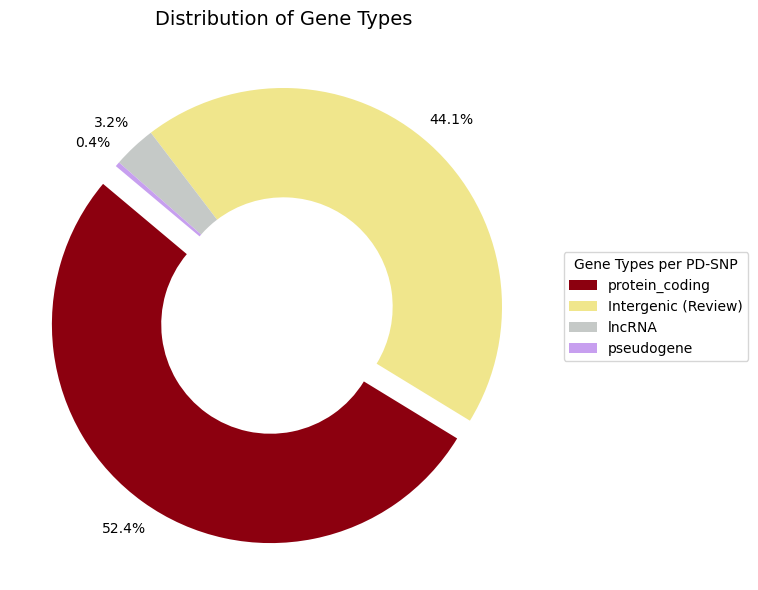

In [86]:
### Now let's get the type of genes that are affected by PD-SNPs as a pie chart
import matplotlib.pyplot as plt

pie_labels = gene_type_edited_clean['Gene Type']
pie_sizes = gene_type_edited_clean['count']
colors = ['#8C000F', '#F0E68C', '#C5C9C7', '#C79FEF']
explode = [0.1 if label == "protein_coding" else 0 for label in pie_labels]
wedgeprops={'width': .5}
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    pie_sizes,
    labels=None,  
    autopct='%1.1f%%',  
    startangle=140,     
    colors=colors,      
    pctdistance=1.15,   
    explode=explode,
    wedgeprops=wedgeprops
)

plt.legend(
    wedges, pie_labels,
    title='Gene Types per PD-SNP',
    loc='center left',
    bbox_to_anchor=(1,0,0.5,1)
)

plt.title("Distribution of Gene Types", fontsize=14)

### Let's save it
plt.tight_layout()
output_path_png = 'Resources/OutputFromExtractionCode/Gene_type_Pie_Chart.png'
plt.savefig(output_path_png, dpi=300,bbox_inches='tight')
plt.show()

In [91]:
### Now let's break it down by chromosome position
Chr_list = filtered_final_df['Chromosome'].value_counts().reset_index()
Chr_list.columns = ['Chromosome', 'count']
desired_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 
 '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']
Chr_list['Chromosome'] = pd.Categorical(Chr_list['Chromosome'], categories=desired_order, ordered=True)
Chr_list = Chr_list.sort_values('Chromosome')
Chr_list

,Chromosome,count
0,1,82
5,2,33
4,3,35
1,4,64
9,5,22
6,6,29
15,7,13
8,8,23
13,9,17
11,10,18


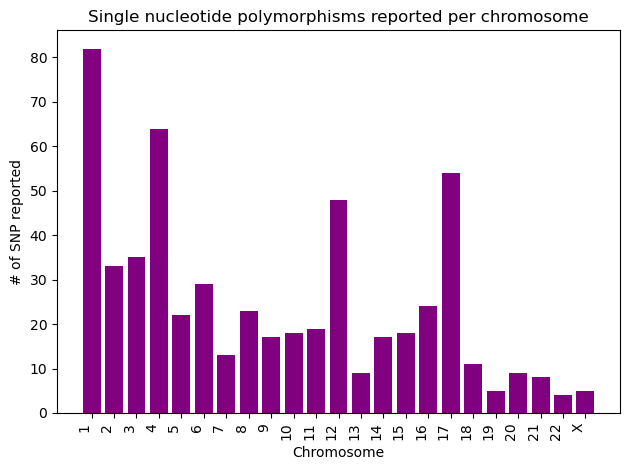

In [92]:
### let's make a bar chart

bar_categories = Chr_list['Chromosome']
bar_values = Chr_list['count']
len_bar_categories = len(bar_categories)
width = 5 / len_bar_categories

plt.bar(bar_categories, bar_values,  color= 'purple')
plt.xlabel('Chromosome')
plt.xticks(rotation=90, ha='right')
plt.ylabel('# of SNP reported')
plt.title('Single nucleotide polymorphisms reported per chromosome')

### Let's save it
plt.tight_layout()
output_path_png = 'Resources/OutputFromExtractionCode/SNP_counts_by__chromosome.png'
plt.savefig(output_path_png, dpi=300,bbox_inches='tight')
plt.show()